This notebook implements a custom convolutional neural network (CNN) to classify Alzheimer's disease from anatomical MRI images. It explores hyperparameter tuning to optimize model performance and applies a distributed training strategy using TensorFlow's MirroredStrategy to accelerate training.

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import pickle, os
from IPython.display import clear_output

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from visualize import visualize_training

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
s3_file_path = 'AD_MRI_classification/preprocessed/data_pre.pkl'
file_path = f"/dbfs/mnt/{s3_file_path}"

with open(file_path, 'rb') as f:
    train_data, train_lab, test_data, test_lab = pickle.load(f)
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Define custom CNN and distributed training strategy

In [0]:
def create_model():
    # three convolutional layers and one fully connected layer
    model = keras.Sequential([
        keras.Input(shape = (128, 128, 1)),

        keras.layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(
            filters=64, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(
            filters=128, 
            kernel_size=(3, 3), 
            activation='relu', 
            kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'), # fully connected layer
        keras.layers.Dense(4, activation='softmax')
    ])
    return model

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

clear_output(wait=False)

Fit model

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
validation_data = (test_data, test_lab_cat)

history = model.fit(
    train_data, 
    train_lab, 
    epochs=25, 
    batch_size=16, 
    validation_data=validation_data, 
    callbacks=[early_stopping]
)

2025-01-09 12:38:18.128096: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 676003840 exceeds 10% of free system memory.
2025-01-09 12:38:30.575120: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 676003840 exceeds 10% of free system memory.
2025-01-09 12:38:32.699238: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/25
131/645 ━━━━━━━━━━━━━━━━━━━━ 6:12 724ms/step - accuracy: 0.3961 - loss: 33.1431

*** WARNING: max output size exceeded, skipping output. ***

644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.4598 - loss: 10.7686

2025-01-09 12:44:47.192181: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.4598 - loss: 10.7571

2025-01-09 12:44:53.776215: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-09 12:45:07.435573: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


645/645 ━━━━━━━━━━━━━━━━━━━━ 394s 605ms/step - accuracy: 0.4599 - loss: 10.7456 - val_accuracy: 0.5227 - val_loss: 1.4790
Epoch 2/25
132/645 ━━━━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.5337 - loss: 1.4690

2025-01-09 12:50:05.484802: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-01-09 12:50:17.043429: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


645/645 ━━━━━━━━━━━━━━━━━━━━ 318s 491ms/step - accuracy: 0.5337 - loss: 1.4689 - val_accuracy: 0.5930 - val_loss: 1.2747
Epoch 3/25
132/645 ━━━━[

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.5840 - loss: 1.2507

2025-01-09 12:56:06.743572: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 348s 538ms/step - accuracy: 0.5840 - loss: 1.2506 - val_accuracy: 0.5289 - val_loss: 1.5386
Epoch 4/25
132/645 ━━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6416 - loss: 1.0965

2025-01-09 13:01:13.715235: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 307s 476ms/step - accuracy: 0.6416 - loss: 1.0964 - val_accuracy: 0.6781 - val_loss: 0.9850
Epoch 5/25


2025-01-09 13:01:21.128020: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


133/645 ━━━━━━━━━━━━━━━━━━━━ 3:35 420ms/s

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.7153 - loss: 0.9120

2025-01-09 13:05:54.396549: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 280s 435ms/step - accuracy: 0.7153 - loss: 0.9120 - val_accuracy: 0.7133 - val_loss: 0.9148
Epoch 6/25
132/645 ━━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8106 - loss: 0.6856

2025-01-09 13:10:54.262690: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 300s 464ms/step - accuracy: 0.8106 - loss: 0.6856 - val_accuracy: 0.7914 - val_loss: 0.6761
Epoch 7/25
132/645 ━━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8850 - loss: 0.4897

2025-01-09 13:15:35.145128: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 281s 435ms/step - accuracy: 0.8850 - loss: 0.4897 - val_accuracy: 0.8484 - val_loss: 0.5915
Epoch 8/25
132/645 ━━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9382 - loss: 0.3593

2025-01-09 13:20:51.357538: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 316s 490ms/step - accuracy: 0.9382 - loss: 0.3593 - val_accuracy: 0.8719 - val_loss: 0.5168
Epoch 9/25


2025-01-09 13:20:58.238085: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


133/645 ━━━━━━━━━━━━━━━━━━━━ 4:34 535ms/s

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9526 - loss: 0.2969

2025-01-09 13:25:54.535736: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 303s 470ms/step - accuracy: 0.9526 - loss: 0.2969 - val_accuracy: 0.8844 - val_loss: 0.4594
Epoch 10/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9596 - loss: 0.2549

2025-01-09 13:31:21.996609: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 328s 508ms/step - accuracy: 0.9596 - loss: 0.2549 - val_accuracy: 0.9008 - val_loss: 0.4645
Epoch 11/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9635 - loss: 0.2530

2025-01-09 13:36:15.237053: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 293s 455ms/step - accuracy: 0.9635 - loss: 0.2529 - val_accuracy: 0.9289 - val_loss: 0.3681
Epoch 12/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9793 - loss: 0.1864

2025-01-09 13:40:54.124220: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 279s 432ms/step - accuracy: 0.9793 - loss: 0.1864 - val_accuracy: 0.8844 - val_loss: 0.4292
Epoch 13/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9721 - loss: 0.2066

2025-01-09 13:45:29.616840: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 276s 427ms/step - accuracy: 0.9721 - loss: 0.2066 - val_accuracy: 0.9336 - val_loss: 0.3312
Epoch 14/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9784 - loss: 0.1698

2025-01-09 13:51:13.659936: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 350s 543ms/step - accuracy: 0.9784 - loss: 0.1698 - val_accuracy: 0.9336 - val_loss: 0.2940
Epoch 15/25
132/645 ━━━━━━━━━━━━━━━━━━━━ 4:47 560ms/step - accuracy: 0.9897 - lo

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9855 - loss: 0.1477

2025-01-09 13:57:05.080574: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 346s 478ms/step - accuracy: 0.9855 - loss: 0.1477 - val_accuracy: 0.9172 - val_loss: 0.3657
Epoch 16/25
132/645 [3

*** WARNING: max output size exceeded, skipping output. ***

644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9829 - loss: 0.1552

2025-01-09 14:02:00.730443: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9829 - loss: 0.1552

2025-01-09 14:02:01.350298: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 299s 447ms/step - accuracy: 0.9829 - loss: 0.1552 - val_accuracy: 0.9078 - val_loss: 0.3997
Epoch 17/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9891 - loss: 0.1262

2025-01-09 14:06:46.015311: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 281s 436ms/step - accuracy: 0.9891 - loss: 0.1262 - val_accuracy: 0.9062 - val_loss: 0.4260
Epoch 18/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9832 - loss: 0.1397

2025-01-09 14:11:16.289692: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 271s 419ms/step - accuracy: 0.9832 - loss: 0.1397 - val_accuracy: 0.9250 - val_loss: 0.3272
Epoch 19/25
132/645 ━

*** WARNING: max output size exceeded, skipping output. ***

645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9829 - loss: 0.1407

2025-01-09 14:15:48.612627: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


645/645 ━━━━━━━━━━━━━━━━━━━━ 272s 422ms/step - accuracy: 0.9829 - loss: 0.1407 - val_accuracy: 0.9336 - val_loss: 0.3460


In [0]:
# Save model and results
cwd = os.getcwd()
results_dir = os.path.join(os.path.dirname(cwd), 'results')

model_file = os.path.join(results_dir, 'model_custom_CNN.h5')
results_file = os.path.join(results_dir, 'history_custom_CNN.pkl')

model.save(model_file)
with open(results_file, 'wb') as f:
    pickle.dump(history, f)
clear_output(wait=False)

print(f"Model saved as: {model_file}")
print(f"Training results saved as: {results_file}")

Visualize model fit

In [0]:
visualize_training(history)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-5063134018802647>, line 1
----> 1 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
      3 # Plot training and validation loss
      4 ax1.set_xlabel('Epochs', fontsize=18)

NameError: name 'plt' is not defined

Predict test data, evaluate accuracy and visualize

In [0]:
# Predict test data
prob=model.predict(test_data)
predict_classes=np.argmax(prob,axis=1)
predict_classes

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_lab, predict_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Accuracy (%)'}, 
            xticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            yticklabels=['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'], 
            ax=ax[0], linewidths=1, linecolor='black')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].set_title('Confusion Matrix')

# Bar plot for the distribution of the test set
train_label_counts = train['label'].value_counts().sort_index()
ax[1].bar(train_label_counts.index, train_label_counts.values, color = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896'])
ax[1].set_xlabel('Class Label')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Training Set')
ax[1].set_xticks(train_label_counts.index)
ax[1].set_xticklabels(['No AD', 'Mild AD', 'Moderate AD', 'Severe AD'])

plt.tight_layout()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-6874464738803293>, line 7
      4 predict_classes
      6 # Generate and plot confusion matrix
----> 7 conf_matrix = confusion_matrix(test_lab, predict_classes)
      8 conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
     10 fig, ax = plt.subplots(1, 2, figsize=(12, 6))

File /databricks/python/lib/python3.12/site-packages/mlflow/utils/autologging_utils/safety.py:580, in safe_patch.<locals>.safe_patch_function(*args, **kwargs)
    578     patch_function.call(call_original, *args, **kwargs)
    579 else:
--> 580     patch_function(call_original, *args, **kwargs)
    582 session.state = "succeeded"
    584 try_log_autologging_event(
    585     AutologgingEventLogger.get_logger().log_patch_function_success,
    586     session,
   (...)
    590     kwargs,
    591 )

File /databr

Overall we do not see a direct link between the test set class accuracies and the number of measurements in the training set. In fact the class with the lowest number of training measurements achieved the second highest accuracy. Therefore, even though it would be ideal to have completely (or moreso) balanced training classes, this is not a major bias in the current model.

Define hyperparameters to tune and the corresponding parameter space

In [0]:
# Same architecture as before, but with hyperparameter ranges
def build_model(hp):

    model = keras.Sequential([
    keras.Input(shape = (128, 128, 1)),  
        
    keras.layers.Conv2D(
        filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 32), 
        kernel_size = hp.Choice('conv_1_kernel', values = [3,3]), 
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_2_filter', min_value = 64, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_2_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)), 
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(
        filters = hp.Int('conv_3_filter', min_value = 96, max_value = 128, step = 32),
        kernel_size = hp.Choice('conv_3_kernel', values = [3,3]),
        activation = 'relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
        
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value = 128, max_value = 256, step = 32),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01)),
        
    keras.layers.Dropout(0.5),
        
    keras.layers.Dense(4, activation = 'softmax')
    ])
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

Initiate tuner

In [0]:
tuner = kt.Hyperband(build_model, objective = 'val_accuracy', max_epochs = 20, factor = 3, directory = 'my_dir', project_name = 'AD_class')
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

Run search

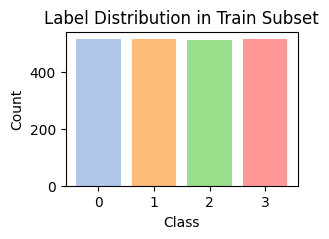

In [0]:
# tune parameters on subset of data to conserve time/memory
subset = []
for label in np.unique(train_lab):
    label_indices = np.where(train_lab == label)[0]
    np.random.shuffle(label_indices)
    subset.extend(label_indices[:int(0.2 * len(label_indices))])
subset = np.array(subset)
train_data_tune = train_data[subset,:,:,:]
train_lab_tune = train_lab[subset]

# Plot bar graph of label distribution in subset
label_counts = np.bincount(train_lab_tune)
labels = np.arange(len(label_counts))

colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']
plt.figure(figsize=(3, 2))
plt.bar(labels, label_counts, tick_label=labels, color=colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Label Distribution in Train Subset')
plt.show()

train_lab_tune_cat = to_categorical(train_lab_tune.astype('int8'))

test_data_tune = test_data.reshape(-1, 128, 128, 1)
test_lab_tune_cat = to_categorical(test_lab.astype('int8'))

In [0]:

tuner.search(train_data_tune, train_lab_tune_cat, epochs = 10, callbacks = [stop_early],
             validation_data = (test_data_tune, test_lab_tune_cat))

Trial 23 Complete [00h 45m 23s]
val_accuracy: 0.5960937738418579

Best val_accuracy So Far: 0.710156261920929
Total elapsed time: 04h 17m 11s

Search: Running Trial #24

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1_filter
3                 |3                 |conv_1_kernel
128               |96                |conv_2_filter
3                 |3                 |conv_2_kernel
128               |96                |conv_3_filter
3                 |3                 |conv_3_kernel
256               |224               |dense_1_units
0.0001            |0.0001            |learning_rate
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.3574 - loss: 18.1078 - val_accuracy: 0.4969 - val_loss: 7.0565
Epoch 2/20
65/65 ━━━━

In [0]:
# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Optimal parameters are as follows:

Filter 1 output dim: {best_hps.get('conv_1_filter')}
Filter 2 output dim: {best_hps.get('conv_2_filter')}
Filter 2 output dim: {best_hps.get('conv_3_filter')}

Dense layer units: {best_hps.get('units')}

Learning Rate: {best_hps.get('learning_rate')}
""")

# Save hps
cwd = os.getcwd()
results_dir = os.path.join(os.path.dirname(cwd), 'results')
hp_file = os.path.join(results_dir, 'best_hps_custom_CNN.pkl')

# Save model
with open(hp_file, 'wb') as f:
    pickle.dump(best_hps, f)
clear_output(wait=False)

print(f"Best hyperparameters saved as: {hp_file}")

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:717)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

Optimal # of epochs

In [0]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_data, train_lab, epochs = 25, validation_data = (test_data, test_lab))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:706)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:508)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:613)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:636)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:295)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
# from sklearn.metrics import confusion_matrix, roc_curve, auc
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Train model with best hyperparameters and best epoch
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(train_data, train_lab, epochs=best_epoch, validation_data=(test_data, test_lab))

# # Predict test data
# predictions = model.predict(test_data)
# predicted_classes = predictions.argmax(axis=1)

# # Confusion Matrix
# conf_matrix = confusion_matrix(test_lab, predicted_classes)
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(test_lab, predictions[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 160)            │     3,010,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,104,324 (11.84 MB)

 Trainable params: 3,104,324 (11.84 MB)

 Non-trainable params: 0 (0.00 B)

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-6777640126419552>, line 7
      5 # Train model with best hyperparameters and best epoch
      6 model = tuner.hypermodel.build(best_hps)
----> 7 history = model.fit(train_data, train_lab, epochs=best_epoch, validation_data=(test_data, test_lab))
      9 # Predict test data
     10 predictions = model.predict(test_data)

AttributeError: 'NoneType' object has no attribute 'fit'